# Auto Price Prediction

In [1]:
#!pip install xgboost # Run one time
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the csv file into a dataframe
df = pd.read_csv("auto_imports.csv")

In [3]:
# Labling the column names into the dataframe
lables = ['symboling','normalized-losses','make','fuel-type','aspiration','num-of-doors','body-style','drive-wheels','engine-location','wheel-base','length','width','height','curb-weight','engine-type','num-of-cylinders','engine-size','fuel-system','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']
df.columns = lables

In [4]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


# Data Preprocessing

In [5]:
df.shape

(200, 26)

In [6]:
df.describe()

,symboling,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg,price
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.830000,98.848000,174.228000,65.898000,53.791500,2555.705000,126.860000,10.170100,25.200000,30.705000,13205.690000
std,1.248557,6.038261,12.347132,2.102904,2.428449,518.594552,41.650501,4.014163,6.432487,6.827227,7966.982558
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000,5118.000000
25%,0.000000,94.500000,166.675000,64.175000,52.000000,2163.000000,97.750000,8.575000,19.000000,25.000000,7775.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,119.500000,9.000000,24.000000,30.000000,10270.000000
75%,2.000000,102.400000,183.500000,66.675000,55.525000,2928.250000,142.000000,9.400000,30.000000,34.000000,16500.750000
max,3.000000,120.900000,208.100000,72.000000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000,45400.000000


In [7]:
# Checking if the data has null values
df.isnull().sum()

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

Although We could not see any null values, there are few values that has '?' character in it, so we should replace it with null values

In [8]:
# Replacing ? into null values
df.replace('?', np.nan, inplace=True)

In [9]:
# Checking for null values again
df.isnull().sum()

symboling             0
normalized-losses    36
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

Now we could find 6 columns has null values -
normalized-losses-36, 
num-of-doors-2, 
bore-4, 
stroke-4, 
horsepower-2, 
peak-rpm-2

In [10]:
# Checking for the datatypes of each columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          200 non-null    int64  
 1   normalized-losses  164 non-null    object 
 2   make               200 non-null    object 
 3   fuel-type          200 non-null    object 
 4   aspiration         200 non-null    object 
 5   num-of-doors       198 non-null    object 
 6   body-style         200 non-null    object 
 7   drive-wheels       200 non-null    object 
 8   engine-location    200 non-null    object 
 9   wheel-base         200 non-null    float64
 10  length             200 non-null    float64
 11  width              200 non-null    float64
 12  height             200 non-null    float64
 13  curb-weight        200 non-null    int64  
 14  engine-type        200 non-null    object 
 15  num-of-cylinders   200 non-null    object 
 16  engine-size        200 non

In [11]:
# converting object datatype columns with the null values into numeric 
df[['normalized-losses','bore','stroke','horsepower','peak-rpm']] = df[['normalized-losses','bore','stroke','horsepower','peak-rpm']].apply(pd.to_numeric)

In [12]:
# converted datatye checking
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          200 non-null    int64  
 1   normalized-losses  164 non-null    float64
 2   make               200 non-null    object 
 3   fuel-type          200 non-null    object 
 4   aspiration         200 non-null    object 
 5   num-of-doors       198 non-null    object 
 6   body-style         200 non-null    object 
 7   drive-wheels       200 non-null    object 
 8   engine-location    200 non-null    object 
 9   wheel-base         200 non-null    float64
 10  length             200 non-null    float64
 11  width              200 non-null    float64
 12  height             200 non-null    float64
 13  curb-weight        200 non-null    int64  
 14  engine-type        200 non-null    object 
 15  num-of-cylinders   200 non-null    object 
 16  engine-size        200 non

In [13]:
# filling the missing values with the mean values of numrical columns
df['normalized-losses'] = df['normalized-losses'].fillna(df['normalized-losses'].mean())
df['bore'] = df['bore'].fillna(df['bore'].mean())
df['stroke'] = df['stroke'].fillna(df['stroke'].mean())
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].mean())
df['peak-rpm'] = df['peak-rpm'].fillna(df['peak-rpm'].mean())

In [14]:
# For a categorical column - num of doors, finding the unique values
df['num-of-doors'].unique()

array(['two', 'four', nan], dtype=object)

In [15]:
# Finding the total count of each categories to find the max repeating category
df['num-of-doors'].astype('category').value_counts()

four    113
two      85
Name: num-of-doors, dtype: int64

In [16]:
# Filling the missing value with the high repeating value
df['num-of-doors'] = df['num-of-doors'].fillna('four')

In [17]:
# Checking for null after removing all the null values
df.isnull().sum()

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

Now we have removed all the null values

### As the dataset is very small, We are not removing the outliers

# EDA and Data Visualization

## Categorical Columns

In [18]:
# Taking out Caterorical data
df_cat = df.select_dtypes(include=['object'])
df_cat.columns

Index(['make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style',
       'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders',
       'fuel-system'],
      dtype='object')

In [19]:
# Counting the number of Caterorical columns
print(len(df_cat.columns))

10


In [20]:
for i in df_cat:
    print(i.upper())
    print('Number of unique values in',i,':',df[i].nunique())
    print('\nThe unique values of',i,':\n',df[i].unique())
    print('\nThe count of each values in',i,':\n',df[i].value_counts(),'\n\n')

MAKE
Number of unique values in make : 22

The unique values of make :
 ['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'mazda' 'mercedes-benz' 'mercury' 'mitsubishi' 'nissan' 'peugot'
 'plymouth' 'porsche' 'renault' 'saab' 'subaru' 'toyota' 'volkswagen'
 'volvo']

The count of each values in make :
 toyota           32
nissan           18
mazda            17
mitsubishi       13
honda            13
volkswagen       12
subaru           12
peugot           11
volvo            11
dodge             9
mercedes-benz     8
bmw               8
plymouth          7
audi              6
saab              6
porsche           4
jaguar            3
chevrolet         3
isuzu             2
renault           2
alfa-romero       2
mercury           1
Name: make, dtype: int64 


FUEL-TYPE
Number of unique values in fuel-type : 2

The unique values of fuel-type :
 ['gas' 'diesel']

The count of each values in fuel-type :
 gas       180
diesel     20
Name: fuel-type, dtype: int64 


## make

<AxesSubplot:xlabel='make'>

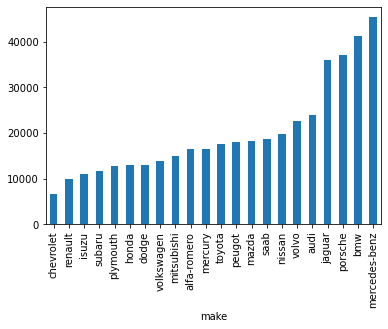

In [21]:
df.groupby('make')['price'].max().sort_values(ascending=True).plot.bar()

From the above bar graphs, we observe that maximum selling price of a single car, 'Mercedes Benz' has the highest followed by 'BMW' and 'porsche'

<AxesSubplot:xlabel='make'>

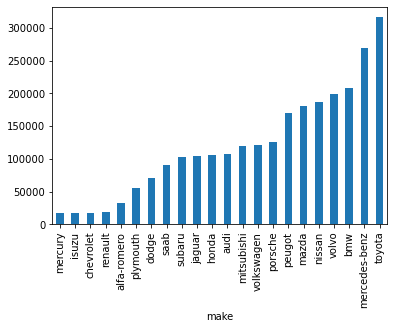

In [22]:
df.groupby('make')['price'].sum().sort_values(ascending=True).plot.bar()

From the above graph, we can understand that 'Toyota' has the highest sales price among all.

<AxesSubplot:xlabel='make'>

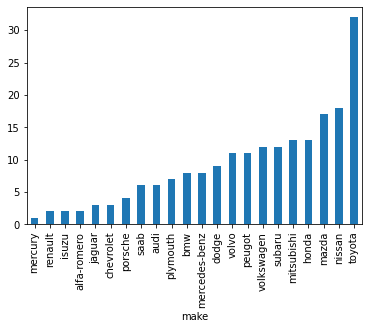

In [23]:
df.groupby('make')['price'].count().sort_values(ascending=True).plot.bar() 

From the above bar graphs, we observe 'toyota' made the largest number of sales when compared to others.

Even though Mercedes cars are expensive having the Maximum price for a single car, It has sold only few when compared to Toyota

## fuel-type

<AxesSubplot:xlabel='fuel-type'>

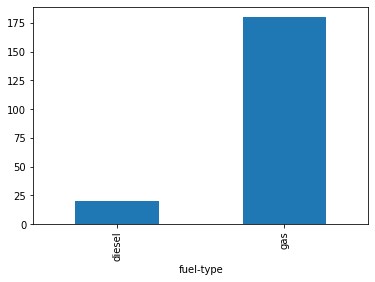

In [24]:
df.groupby('fuel-type')['price'].count().sort_values(ascending=True).plot.bar()

From the above, we observe that the cars that runs on 'Gas' is sold more

## aspiration

<AxesSubplot:xlabel='aspiration'>

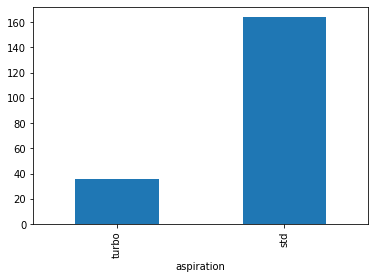

In [25]:
df.groupby('aspiration')['price'].count().sort_values(ascending=True).plot.bar()

## num-of-doors

<AxesSubplot:xlabel='num-of-doors'>

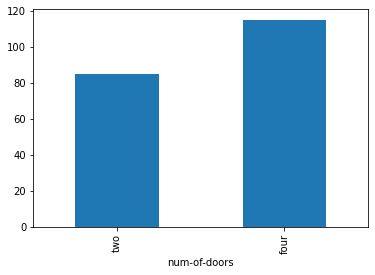

In [26]:
df.groupby('num-of-doors')['price'].count().sort_values(ascending=True).plot.bar()

## body-style

<AxesSubplot:xlabel='body-style'>

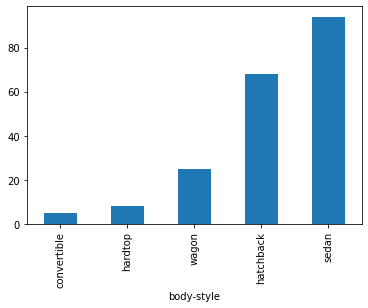

In [27]:
df.groupby('body-style')['price'].count().sort_values(ascending=True).plot.bar()

## drive-wheels

<AxesSubplot:xlabel='drive-wheels'>

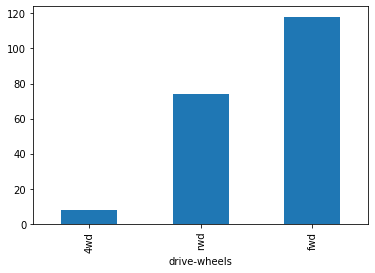

In [28]:
df.groupby('drive-wheels')['price'].count().sort_values(ascending=True).plot.bar()

## engine-location

<AxesSubplot:xlabel='engine-location'>

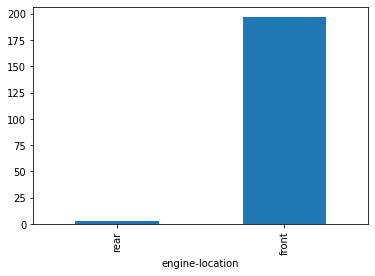

In [29]:
df.groupby('engine-location')['price'].count().sort_values(ascending=True).plot.bar()

## engine-type

<AxesSubplot:xlabel='engine-type'>

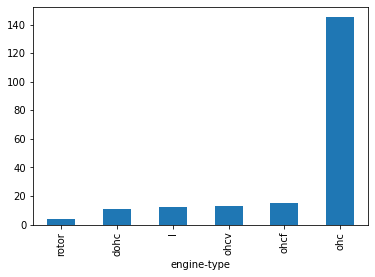

In [30]:
df.groupby('engine-type')['price'].count().sort_values(ascending=True).plot.bar()

## num-of-cylinders

<AxesSubplot:xlabel='num-of-cylinders'>

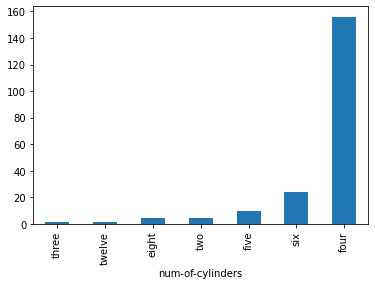

In [31]:
df.groupby('num-of-cylinders')['price'].count().sort_values(ascending=True).plot.bar()

## fuel-system

<AxesSubplot:xlabel='fuel-system'>

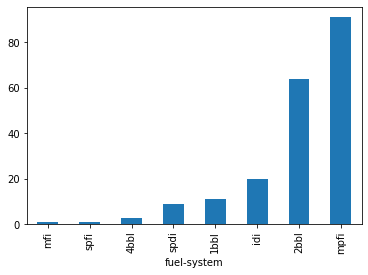

In [32]:
df.groupby('fuel-system')['price'].count().sort_values(ascending=True).plot.bar()

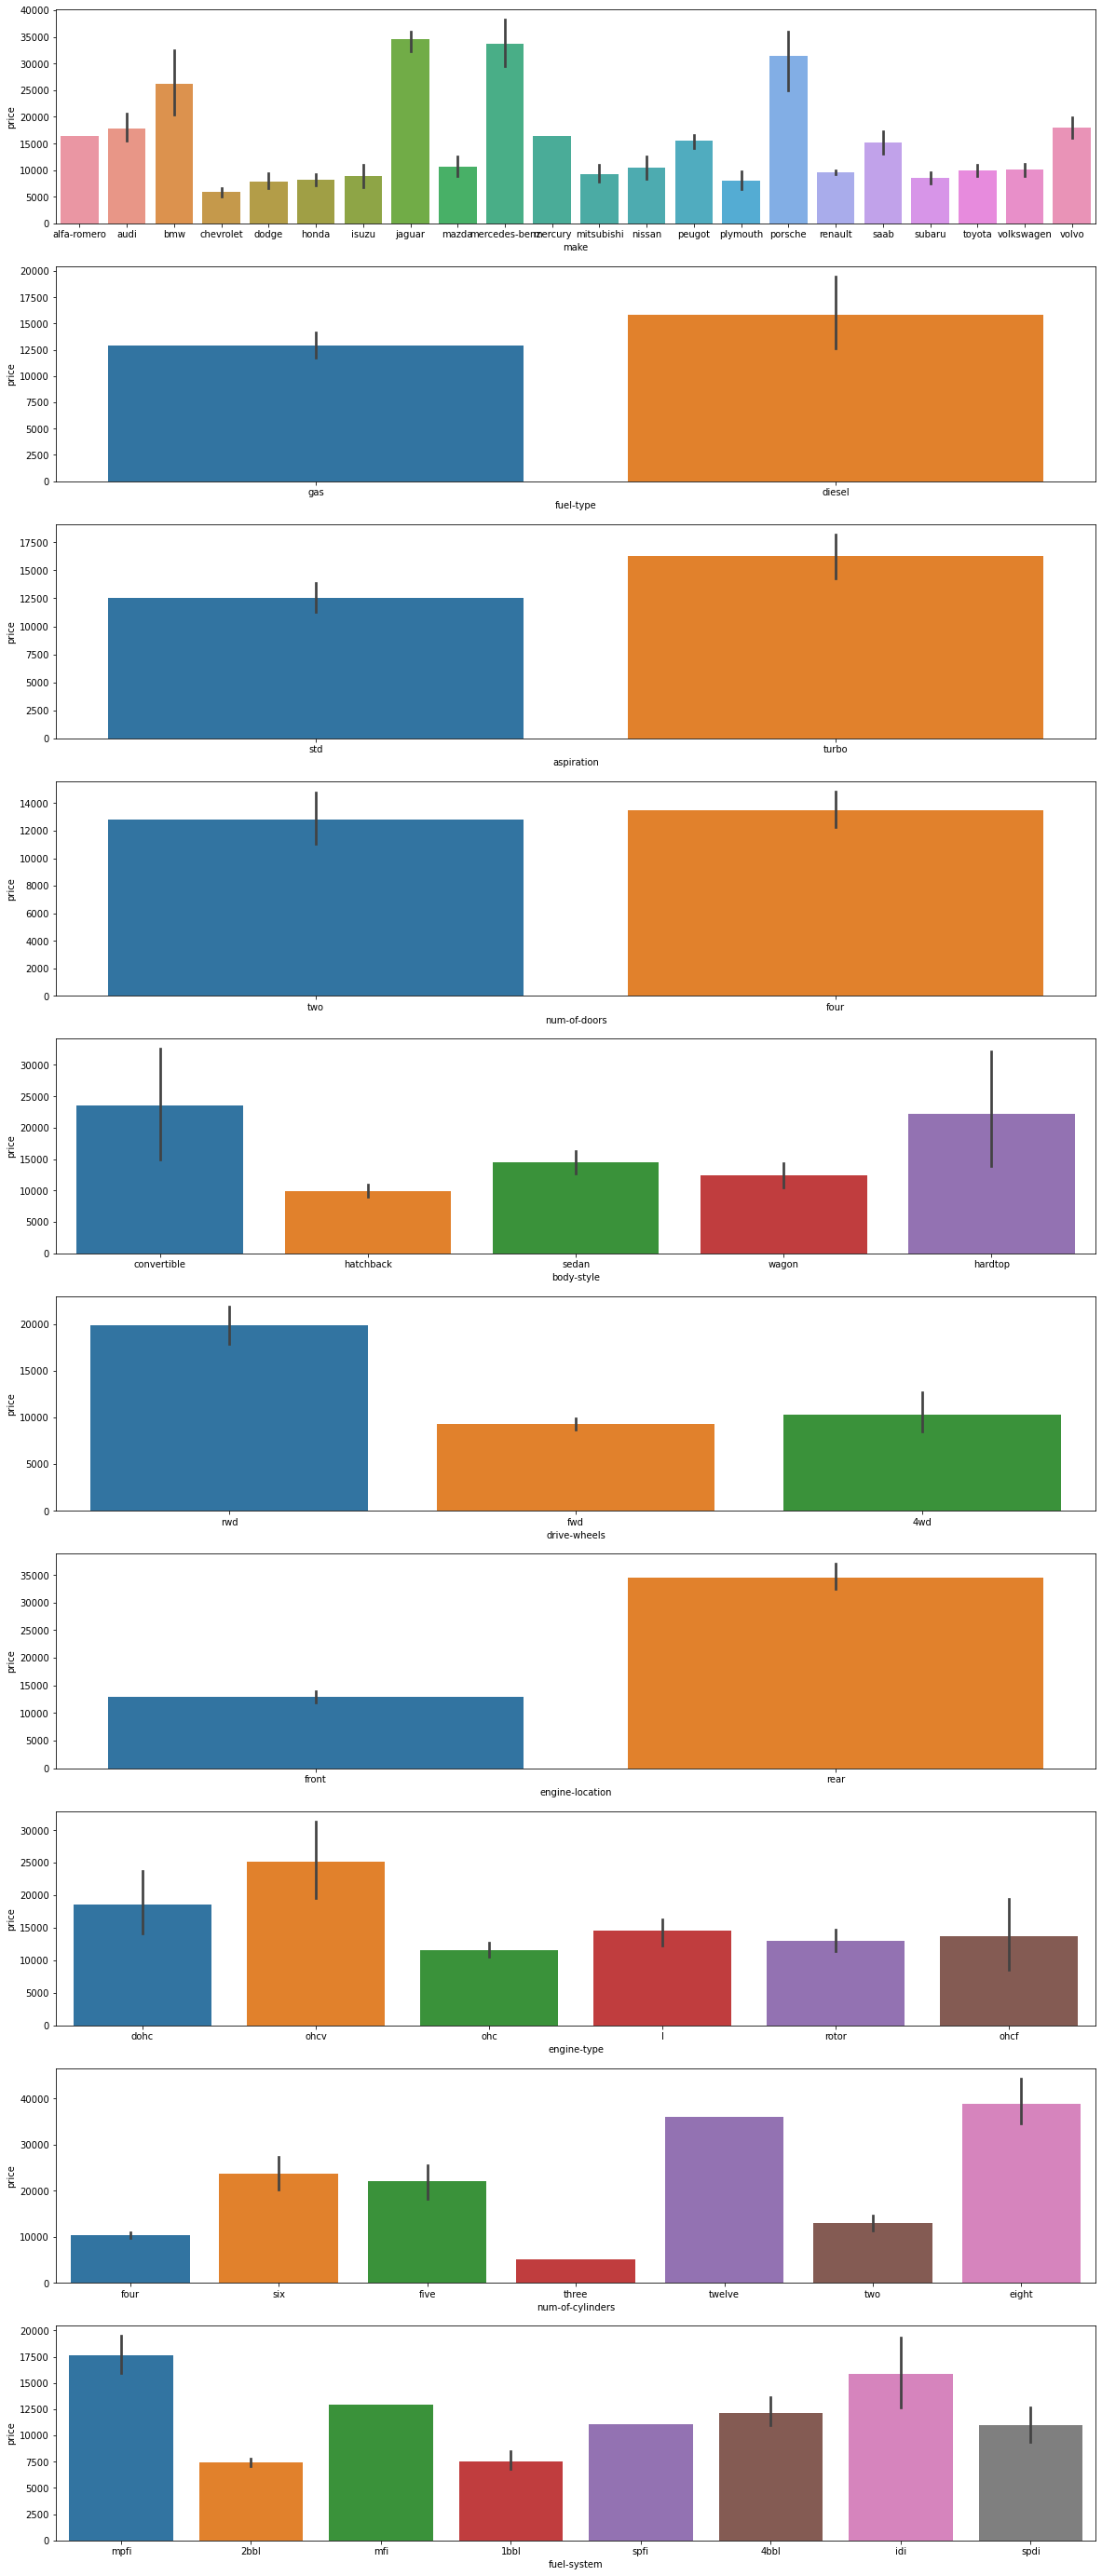

In [33]:
fig, axes = plt.subplots(10,1,figsize=(20,50))

for i in range(len(df_cat.columns)):
    X = df_cat.columns[i]
    sns.barplot(data = df,x = X, y = 'price', ax=axes[i])

# Numerical Data

In [34]:
df_num = df._get_numeric_data()
df_num.columns

Index(['symboling', 'normalized-losses', 'wheel-base', 'length', 'width',
       'height', 'curb-weight', 'engine-size', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

In [35]:
print(len(df_num.columns))

16


In [36]:
for i in df_cat:
    print(i.upper())
    print('\n\n',i,':\n',df[i].describe())

MAKE


 make :
 count        200
unique        22
top       toyota
freq          32
Name: make, dtype: object
FUEL-TYPE


 fuel-type :
 count     200
unique      2
top       gas
freq      180
Name: fuel-type, dtype: object
ASPIRATION


 aspiration :
 count     200
unique      2
top       std
freq      164
Name: aspiration, dtype: object
NUM-OF-DOORS


 num-of-doors :
 count      200
unique       2
top       four
freq       115
Name: num-of-doors, dtype: object
BODY-STYLE


 body-style :
 count       200
unique        5
top       sedan
freq         94
Name: body-style, dtype: object
DRIVE-WHEELS


 drive-wheels :
 count     200
unique      3
top       fwd
freq      118
Name: drive-wheels, dtype: object
ENGINE-LOCATION


 engine-location :
 count       200
unique        2
top       front
freq        197
Name: engine-location, dtype: object
ENGINE-TYPE


 engine-type :
 count     200
unique      6
top       ohc
freq      145
Name: engine-type, dtype: object
NUM-OF-CYLINDERS


 num-of-cyli

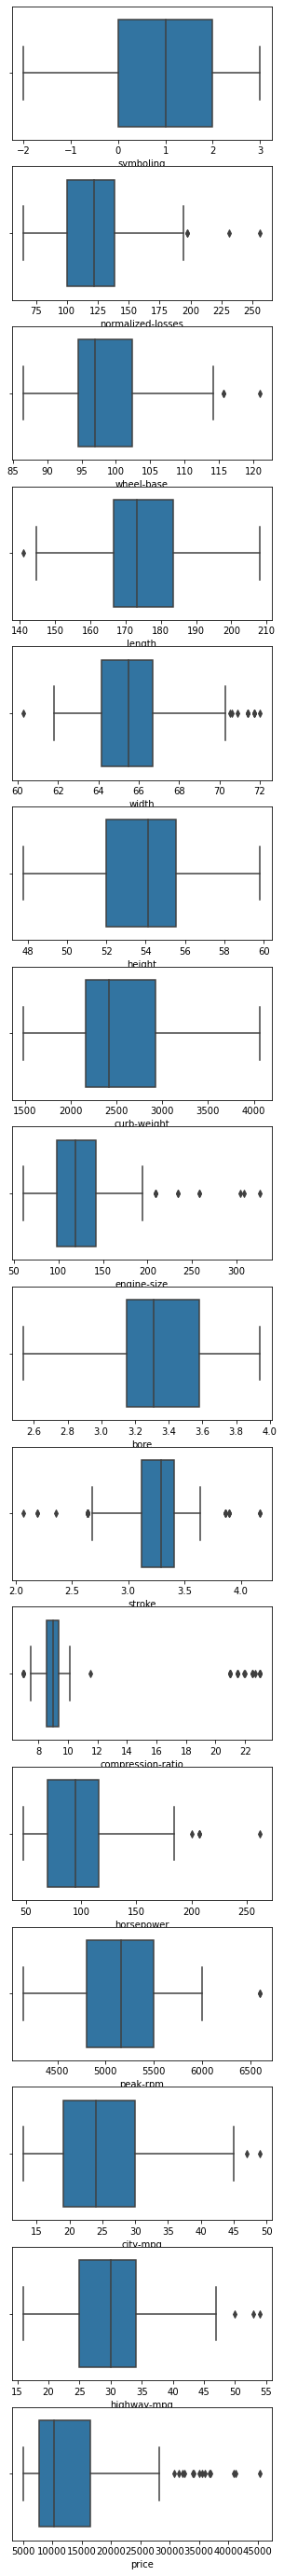

In [37]:
fig, axes = plt.subplots(16,1,figsize=(5,50))

for i in range(len(df_num.columns)):
    X = df_num.columns[i]
    sns.boxplot(data = df,x = X, ax=axes[i])

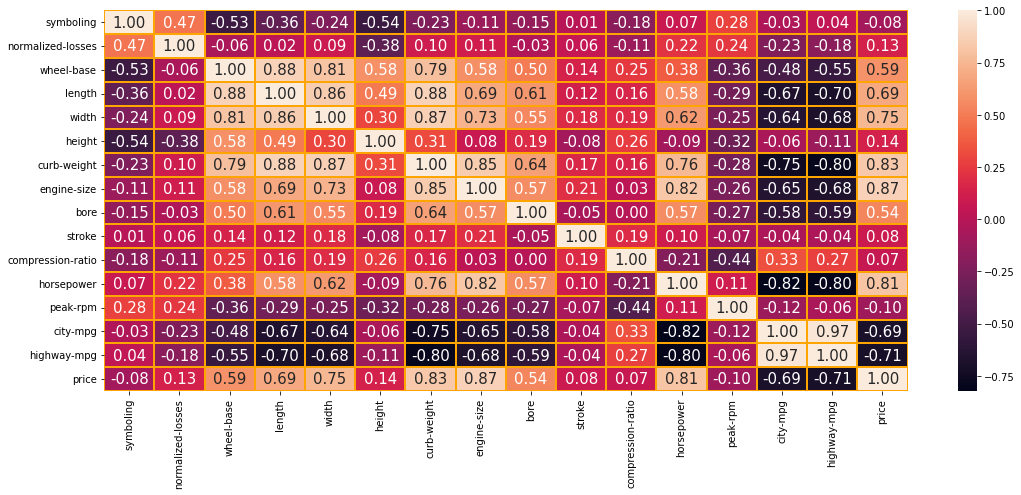

In [38]:
plt.figure(figsize = (18, 7))
sns.heatmap(df_num.corr(), annot = True, fmt = '0.2f', annot_kws = {'size' : 15}, linewidth = 2, linecolor = 'orange')
plt.show()

From the above correlation, we can observe that 'Highway - mpg' is Negatively correlated with price and 
'Engine size' is positively correlated

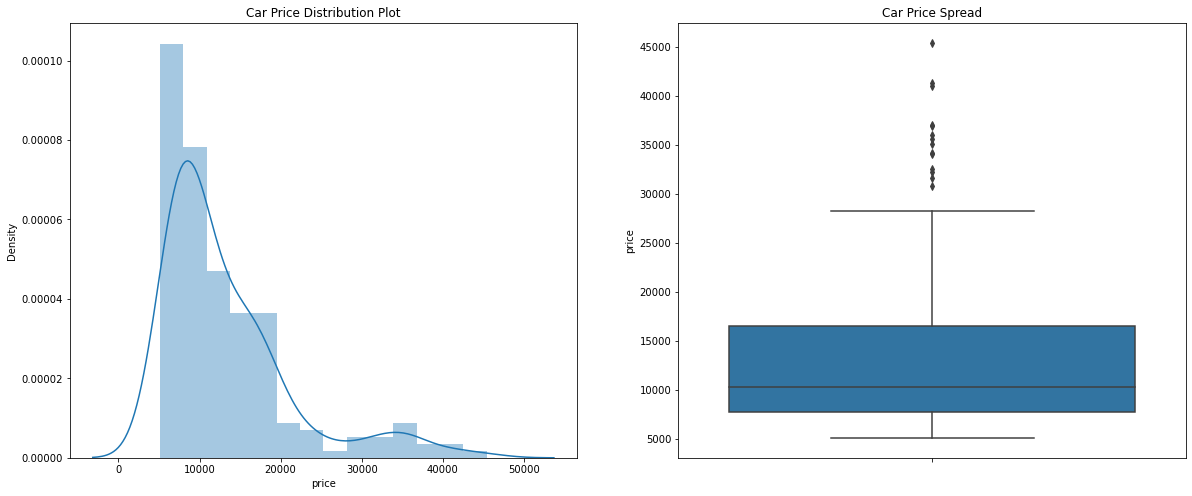

In [39]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('Car Price Distribution Plot')
sns.distplot(df["price"])

plt.subplot(1,2,2)
plt.title('Car Price Spread')
sns.boxplot(y=df["price"])

plt.show()

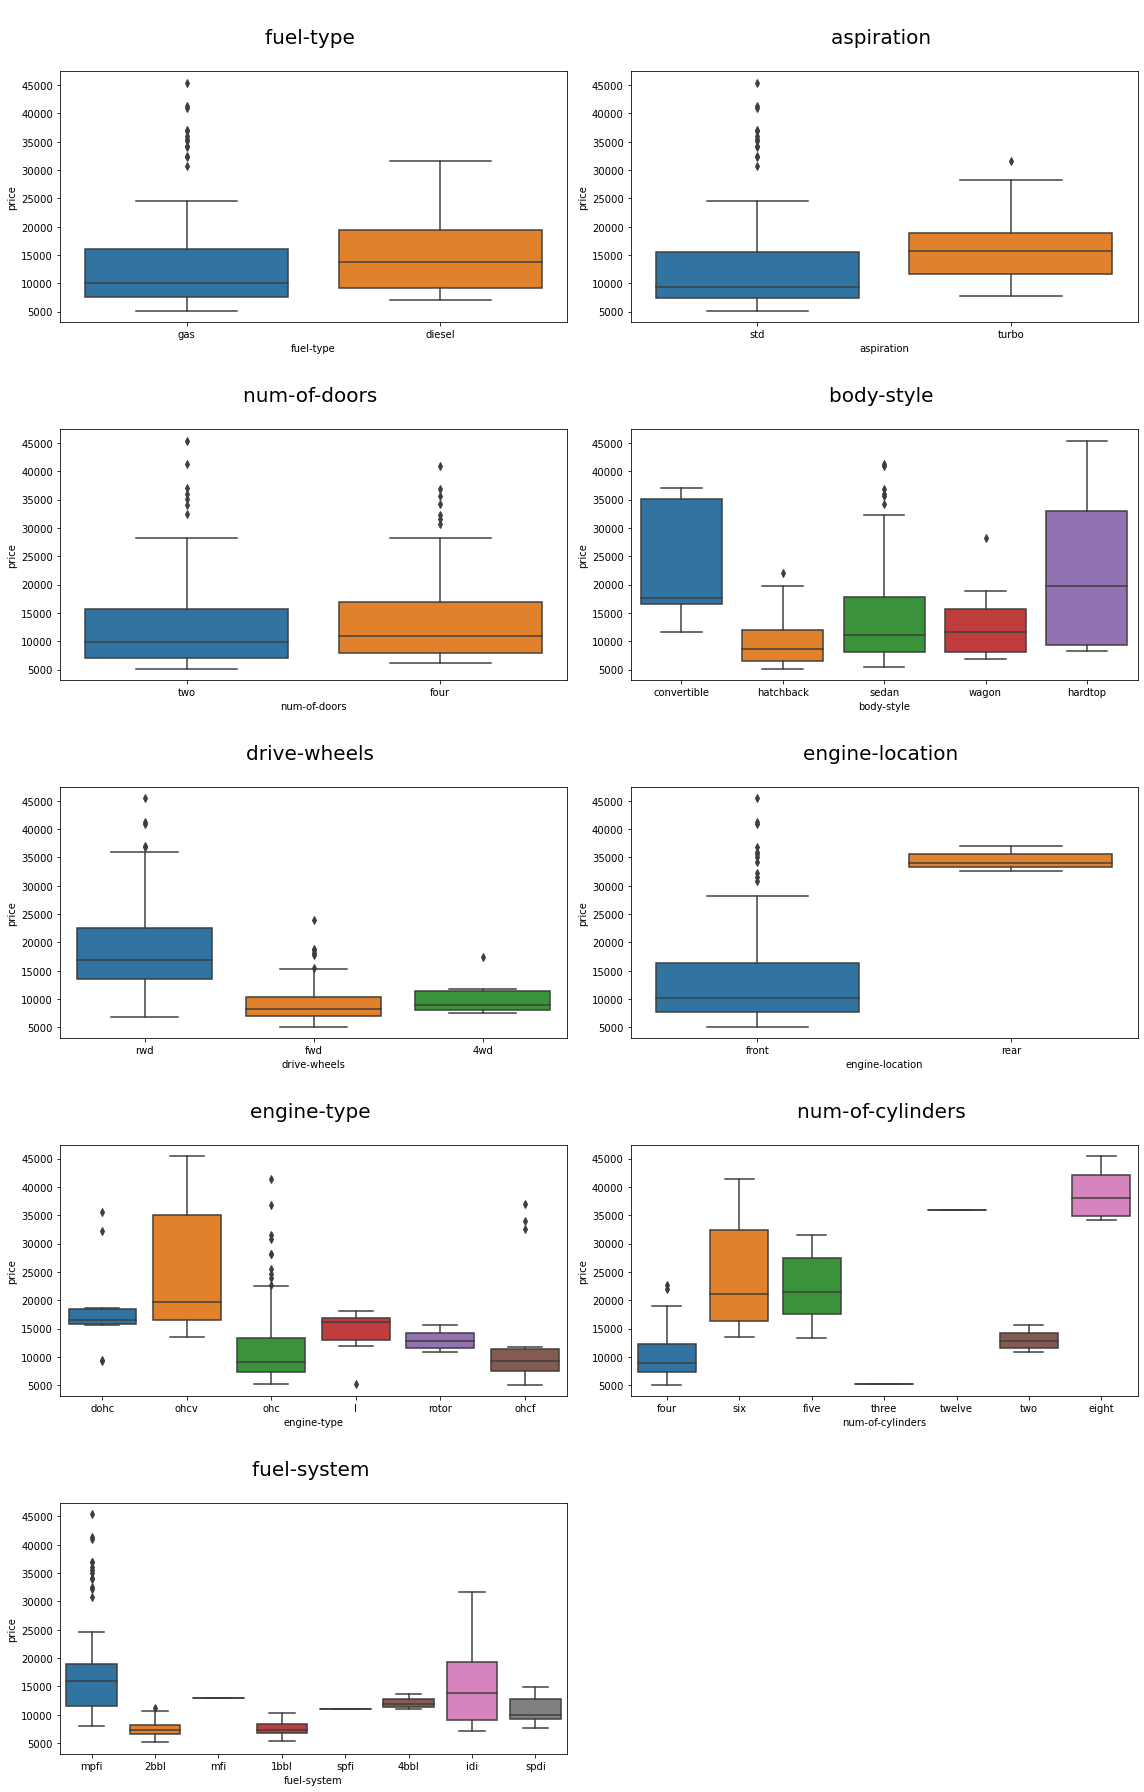

In [40]:
plt.figure(figsize = (16, 25))
plotnumber = 1

for i in range(1, len(df_cat.columns)):
    if plotnumber <= 10:
        ax = plt.subplot(5, 2, plotnumber)
        sns.boxplot(x = df_cat.columns[i] ,y = df['price'], data = df, ax = ax)
        plt.title(f"\n{df_cat.columns[i]} \n", fontsize = 20)
        
    plotnumber += 1

plt.tight_layout()
plt.show()

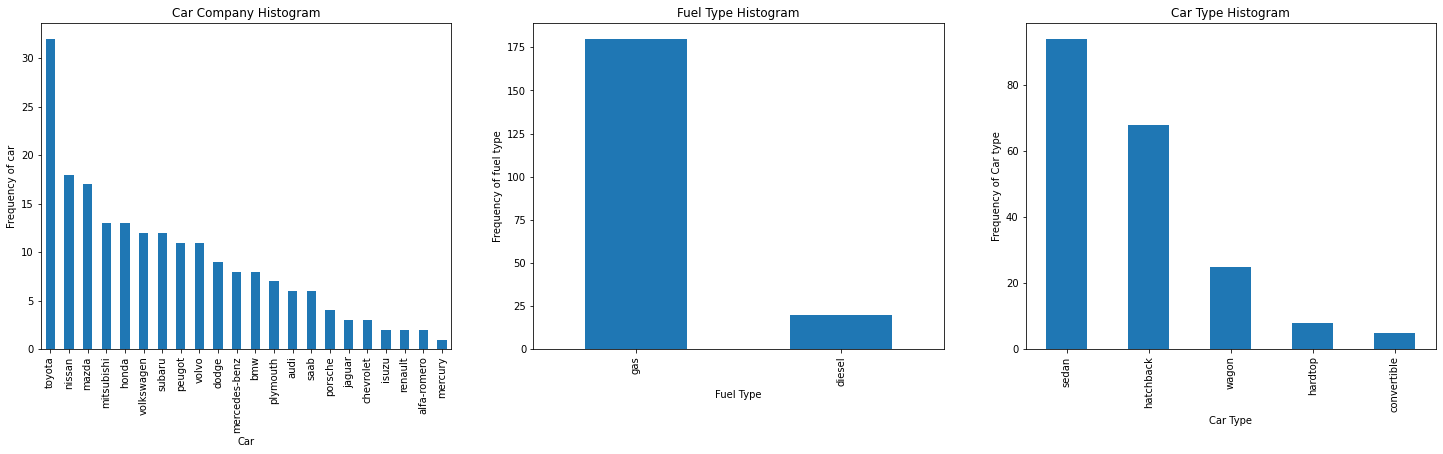

In [41]:
plt.figure(figsize=(25, 6))

plt.subplot(1,3,1)
plt1 = df["make"].value_counts().plot(kind = 'bar')
plt.title('Car Company Histogram')
plt1.set(xlabel = 'Car', ylabel='Frequency of car')

plt.subplot(1,3,2)
plt1 = df["fuel-type"].value_counts().plot(kind = 'bar')
plt.title('Fuel Type Histogram')
plt1.set(xlabel = 'Fuel Type', ylabel='Frequency of fuel type')

plt.subplot(1,3,3)
plt1 = df["body-style"].value_counts().plot(kind = 'bar')
plt.title('Car Type Histogram')
plt1.set(xlabel = 'Car Type', ylabel='Frequency of Car type')

plt.show()


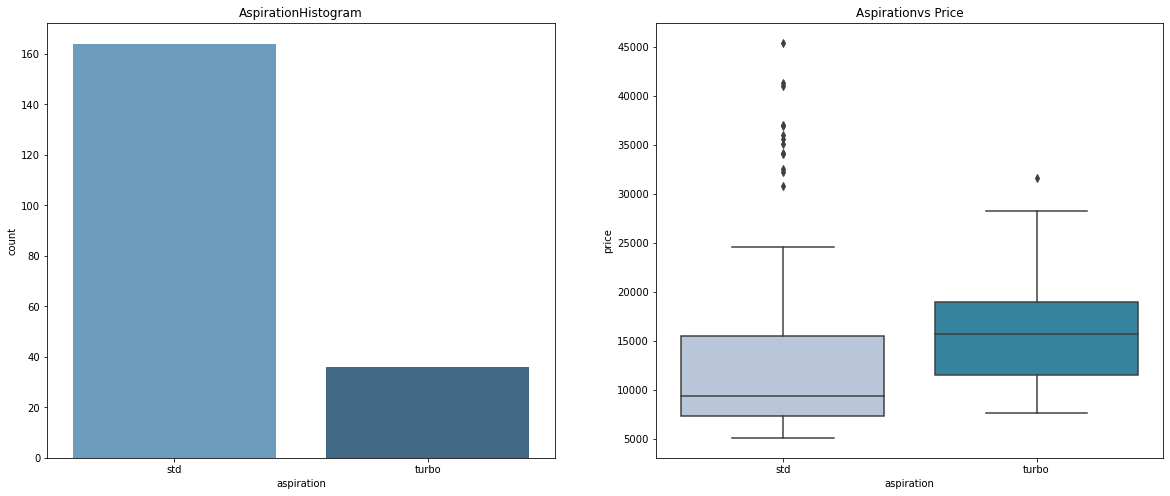

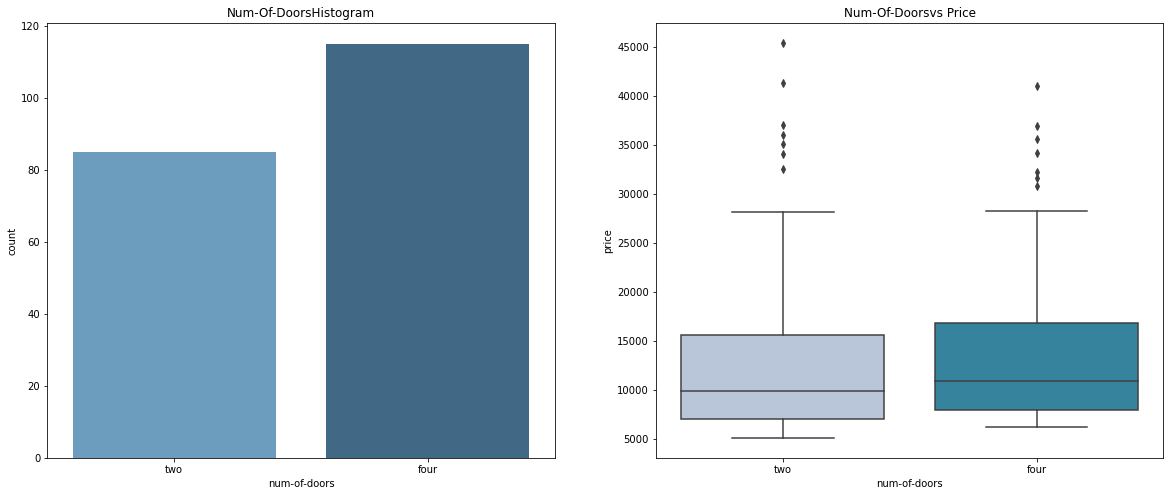

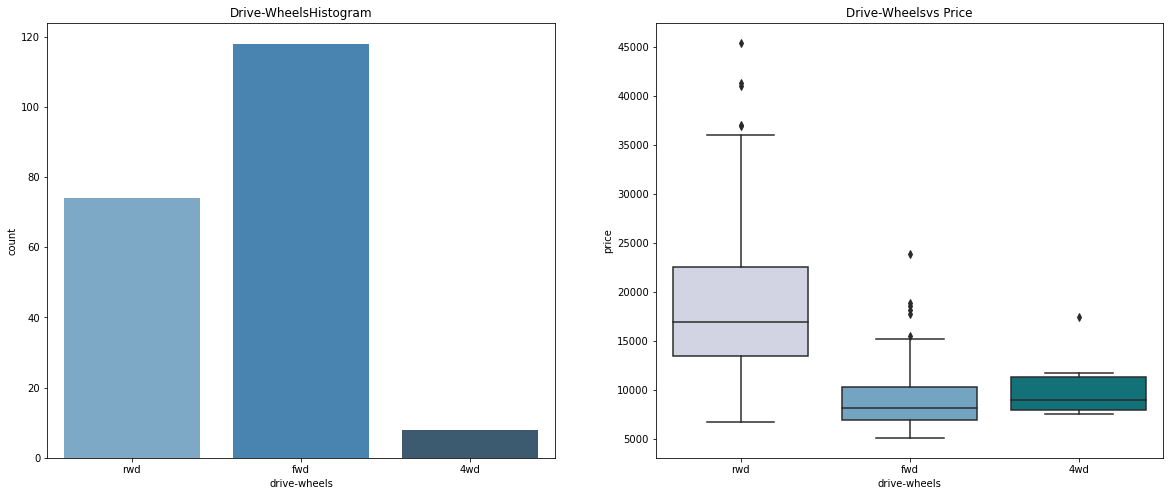

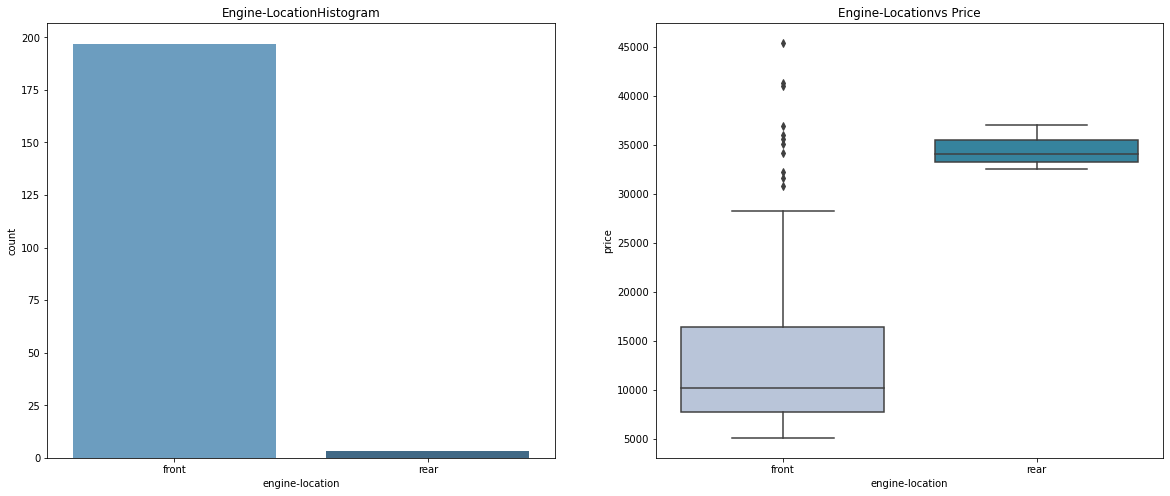

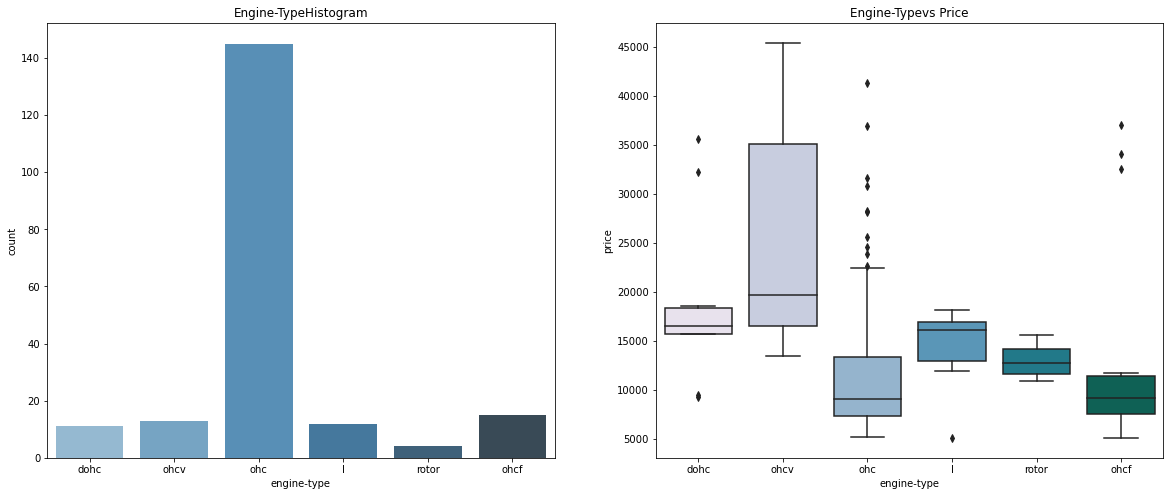

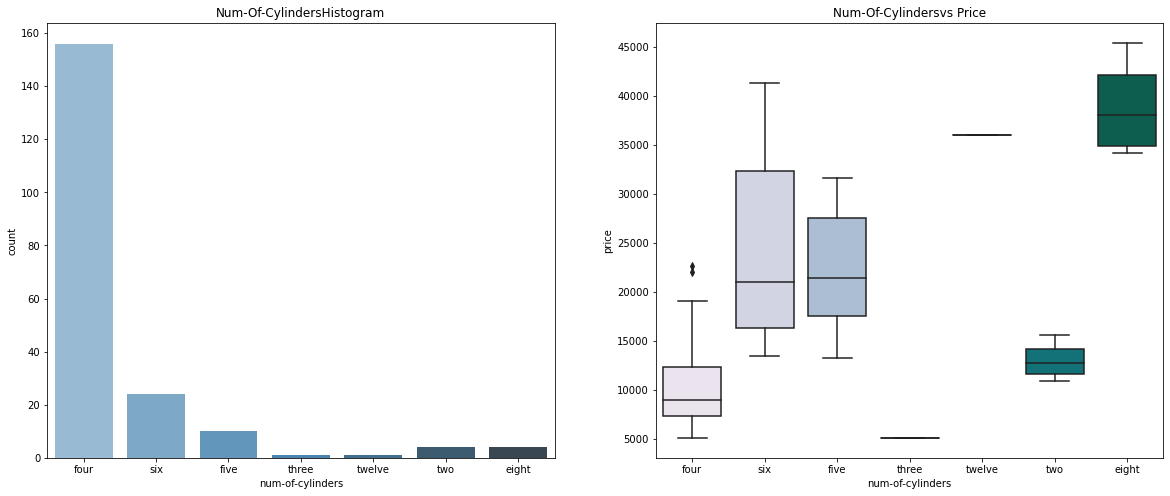

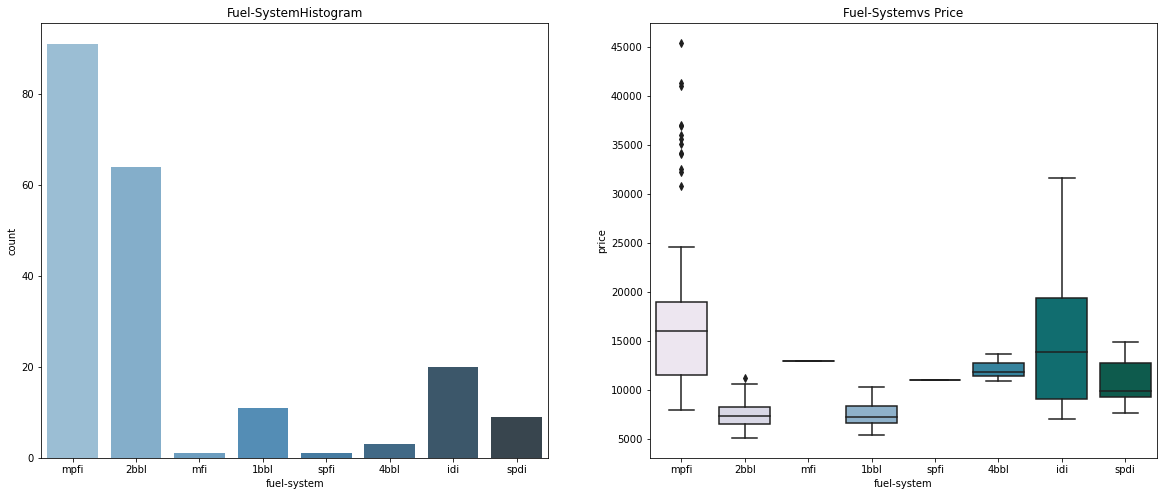

In [42]:
cat_columns = ['aspiration', 'num-of-doors', 'drive-wheels', 'engine-location', 'engine-type', 'num-of-cylinders', 'fuel-system']
for feature in cat_columns:
    plt.figure(figsize=(20,8))

    plt.subplot(1,2,1)
    plt.title(feature.title() + 'Histogram')
    sns.countplot(df[feature], palette=("Blues_d"))

    plt.subplot(1,2,2)
    plt.title(feature.title() + 'vs Price')
    sns.boxplot(x=df[feature], y=df["price"], palette=("PuBuGn"))

    plt.show()

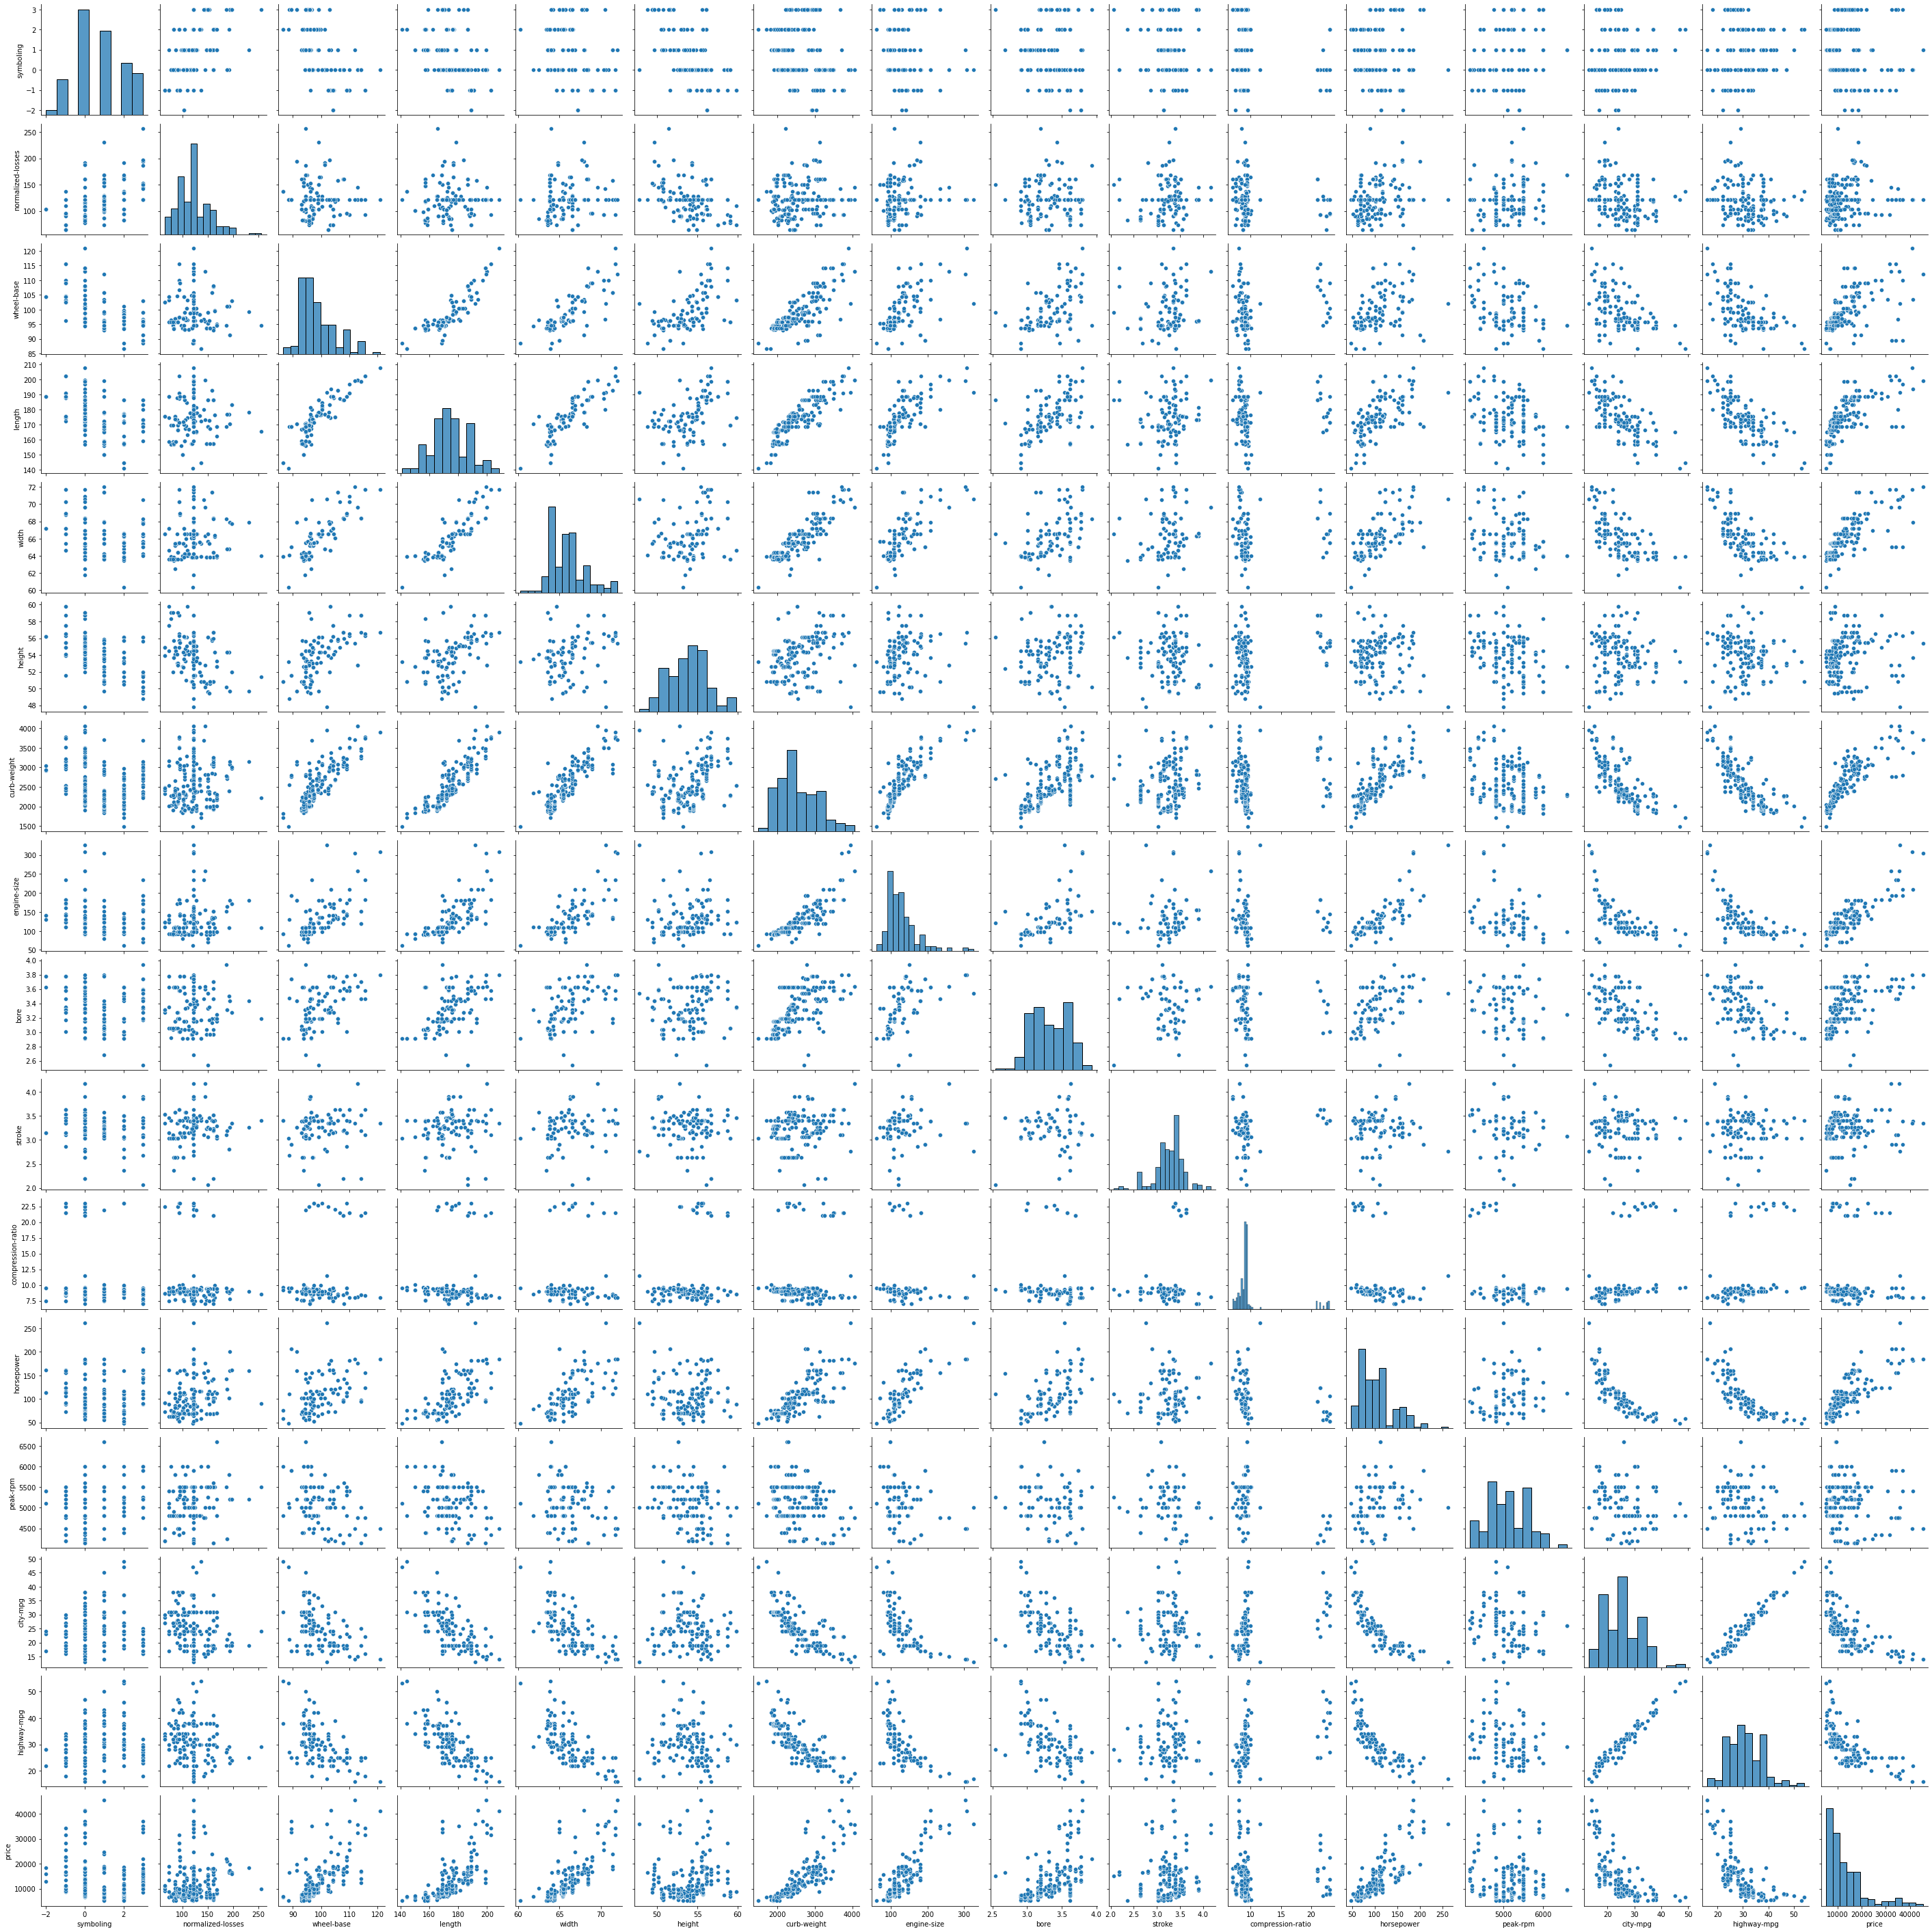

In [43]:
sns.pairplot(df)
plt.show()

In [44]:
# lable encoding is to convert categorical data into nummbers
label_encoder = preprocessing.LabelEncoder()
df['symboling']= label_encoder.fit_transform(df['symboling'])
df['make']= label_encoder.fit_transform(df['make'])
df['fuel-type']= label_encoder.fit_transform(df['fuel-type'])
df['aspiration']= label_encoder.fit_transform(df['aspiration'])
df['num-of-doors']= label_encoder.fit_transform(df['num-of-doors'])
df['body-style']= label_encoder.fit_transform(df['body-style'])
df['drive-wheels']= label_encoder.fit_transform(df['drive-wheels'])
df['engine-location']= label_encoder.fit_transform(df['engine-location'])
df['engine-type']= label_encoder.fit_transform(df['engine-type'])
df['num-of-cylinders']= label_encoder.fit_transform(df['num-of-cylinders'])
df['fuel-system']= label_encoder.fit_transform(df['fuel-system'])

# Model Training and Evaluation

In [45]:
X = df.iloc[:,:-1]
y = df.price

## Linear Regression

In [46]:
# Spliiting Train and Test dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 10, random_state = 25)

# Modle Training and Evaluation
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
y_predict = model_lr.predict(X_test)
print('Accuracy of Linear Regression: ',r2_score(y_test,y_predict))

Accuracy of Linear Regression:  0.9690057817897119


## Logistic Regression

In [47]:
# Spliiting Train and Test dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 10, random_state = 25)

# Modle Training and evaluation
model_lg = LogisticRegression()
model_lg.fit(X_train,y_train)
y_predict = model_lg.predict(X_test)
print('Accuracy of Logistic Regression: ',r2_score(y_test,y_predict))

Accuracy of Logistic Regression:  0.9484361971943301


# Random Forest

In [48]:
# Spliiting Train and Test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 10, random_state = 10)

# Modle Training and evaluation
model_rf = RandomForestRegressor()
model_rf.fit(X_train,y_train)
Y_pre = model_rf.predict(X_test)
print('Accuracy of Random Forest: ',r2_score(y_test,Y_pre))

Accuracy of Random Forest:  0.9662713917270088


# KNN

In [49]:
# Spliiting Train and Test dataset
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 10, random_state = 20)

# Modle Training and evaluation
model_knn = KNeighborsRegressor(n_neighbors=4)
model_knn.fit(X_train,y_train)
Y_pre = model_knn.predict(X_test)
print('Accuracy of KNN: ',r2_score(y_test,Y_pre))

Accuracy of KNN:  0.9711458079700804


# XGBoost

In [50]:
# Spliiting Train and Test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=15, random_state=10)

# Modle Training and evaluation
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
print('Accuracy of XGBoost: ',r2_score(y_test,y_pred))

Accuracy of XGBoost:  0.9612452197567807


# SVM

In [51]:
# Spliiting Train and Test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10, random_state=20)

# Choosing the best parameters
parameters = {'kernel':['rbf','linear'],
             'C':[1,5,8,10,12],
             'gamma':[0.1,0.5,0.8,1]}
             
svc = SVR()
skf = StratifiedKFold(n_splits=2)
grid_model = GridSearchCV(svc, parameters, cv=skf)

grid_model.fit(X_train, y_train)

print("Best Parameters: ", grid_model.best_params_)
print("Best Score: ", grid_model.best_score_)

Best Parameters:  {'C': 12, 'gamma': 0.1, 'kernel': 'linear'}
Best Score:  0.5113423860735389


In [52]:
# Modle Training and evaluation
model_svm = SVR(kernel='linear',C=1,gamma = 0.1)
model_svm.fit(X_train,y_train)

y_predict = model_svm.predict(X_test)
print('Accuracy of SVM: ',r2_score(y_test,y_predict))

Accuracy of SVM:  0.18324106738586765


# Conclusion

We have been given with the data of 1985 Auto Imports Database which consist of 26 columns and 200 rows. The following steps was followed:

1) Data Cleaning

2) Data Pre-Processing

3) Data Analysis

4) Data Visualization

5) Model Training (Linear Regression, Logistic Regression, Random Forest, KNN, XGBoost, SVM)

6) Model Evaluation

#### Challenges faced:
1) Nan values were not in the direct form.

#### Model Comparison Report:
We have trained the data with 6 Regression models - Linear Regression, Logistic Regression, Random Forest, KNN, XGBoost, SVM.

#### Best model:
KNN gives the best accuracy of 97.1%. 


# Final Analysis

With this project, we have built a model that can predict with 97.1% of accuracy the price of cars, given a set of features. This information can have an enormous value for business strategies when trying to understand how to estimate the value of a vehicle and, more importantly, the key factors that determine its pricing.

Therefore, 16 characteristic variables including symboling,make,fuel-type,num-of-doors,body-style,drive-wheels,wheel-base,length,width,engine-size,fuel-system,bore,horsepower,peak-rpm,city-mpg and highway-mpg are selected as the major influencing factors of the car price.